In [46]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier

In [59]:
Titanic_data=pd.read_csv(r'/Users/dumsi/Downloads/titanic/train.csv')
Titanic_data['Title'] = Titanic_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
Titanic_data.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)
Titanic_data.fillna({'Age':Titanic_data['Age'].mean()},inplace=True)
Titanic_data.dropna(inplace=True)
x=Titanic_data.drop(columns='Survived')
y=Titanic_data['Survived']


#x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=125)



col_tf=ColumnTransformer([('Sex_to_numerical',OrdinalEncoder(categories=[['female','male']]),['Sex']),
                          ('Embarked_to_numerical',OneHotEncoder(handle_unknown='ignore'),['Embarked']),
                          ('Title_to_numerical',OneHotEncoder(handle_unknown='ignore'),['Title'])],remainder='passthrough')
pip=Pipeline([('column_transformer',col_tf),('scaling',MinMaxScaler())])



x1=pip.fit_transform(x)
onehotenco=col_tf.named_transformers_['Embarked_to_numerical'].get_feature_names_out(['Embarked']).tolist()
onehotenco1=col_tf.named_transformers_['Title_to_numerical'].get_feature_names_out(['Title']).tolist()
changed_col=['Sex']+onehotenco+onehotenco1
half_col=[]
for i in x.columns:
    if i not in ['Sex','Embarked','Title']:
        half_col.append(i)
final_col=changed_col+half_col 
x=pd.DataFrame(x1,columns=final_col,index=x.index)



model=BaggingClassifier(SGDClassifier(),n_estimators=300,max_samples=75,bootstrap=True,n_jobs=-1)
model=model.fit(x,y)

cv=cross_validate(model,x,y,cv=5,scoring='f1_macro',return_train_score=True)
print('train accracy:',cv['train_score'].mean())
print('test accuracy:',cv['test_score'].mean())


train accracy: 0.8221018002159026
test accuracy: 0.8117114318029456


In [60]:
Titanic_data_test=pd.read_csv(r'/Users/dumsi/Downloads/titanic/test.csv')
Titanic_data_test['Title'] = Titanic_data_test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

Titanic_data_test.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)
Titanic_data_test.fillna({'Age':Titanic_data['Age'].mean(),'Fare':Titanic_data['Fare'].mean()},inplace=True)
x_test=Titanic_data_test
x_t=pip.transform(x_test)
x_test=pd.DataFrame(x_t,columns=final_col,index=x_test.index)
x_test

y_pred=model.predict(x_test)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

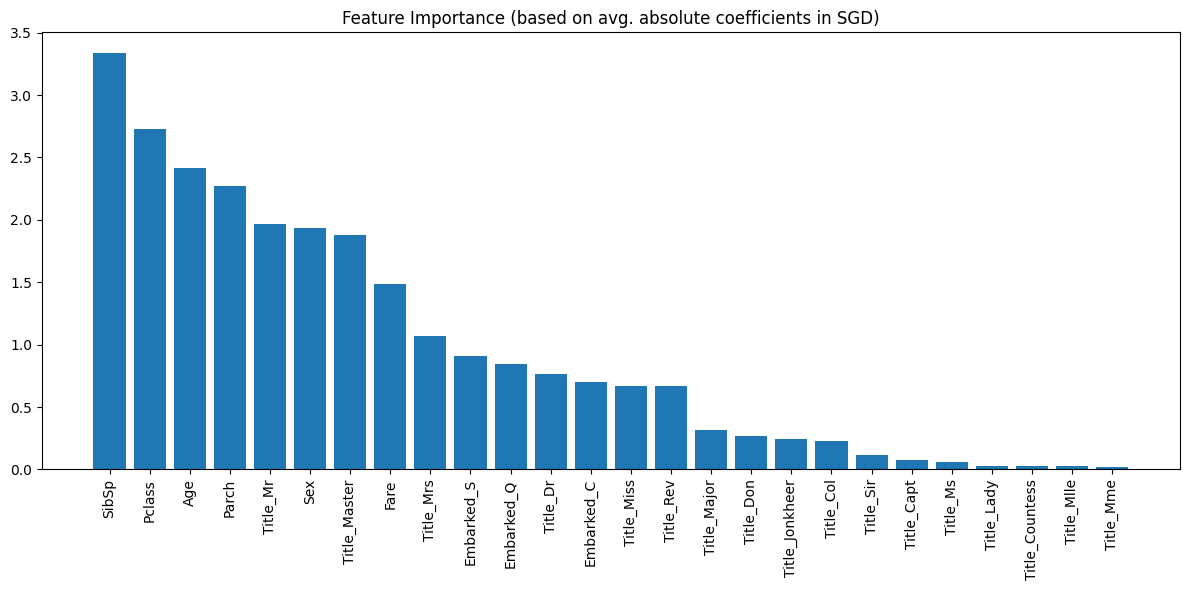

In [62]:
import numpy as np
import matplotlib.pyplot as plt


coefs = []
for est in model.estimators_:
    if hasattr(est, 'coef_'):
        coefs.append(np.abs(est.coef_[0]))  

avg_coef = np.mean(coefs, axis=0)


importance = avg_coef
indices = np.argsort(importance)[::-1]
feature_names_sorted = np.array(final_col)[indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), feature_names_sorted, rotation=90)
plt.title("Feature Importance (based on avg. absolute coefficients in SGD)")
plt.tight_layout()
plt.show()
